In [2]:
%load_ext autoreload
%autoreload 2
from palmari.processing import *
from palmari import Experiment
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
exp = Experiment(data_folder="/Users/hverdier/palm_tools_data/DATA_FOLDER",
    export_folder="/Users/hverdier/palm_tools_data/EXPORT_FOLDER")

In [5]:
# Indicate conditions in the index_df table of the Experiment
# This can be done automatically if you create a subclass of Experiment
exp.index_df["condition"] = "A"
exp.index_df.loc[exp.index_df.file.str.contains("B"),"condition"] = "B"

In [6]:
tp = TifPipeline.from_dict({"name":"coucou"})

In [7]:
tp = TifPipeline.from_dict({
    "name":"test",
    "movie_preprocessors":[{"WindowPercentileFilter":{"percentile":10,"window_size":300}}]
})

In [8]:
tp2 = TifPipeline.from_dict({
    "name":"stricter_than_default",
    "localizer":{"DefaultLocalizer":{"threshold_factor":1.5}},
})

In [9]:
print(tp2)

TIF Processing pipeline
-----------------------
Movie preprocessing steps :
-----------------------
Localizer :
	 Default Localizer (DefaultLocalizer) :
		 threshold_factor : 1.5

-----------------------
Localization processing steps :
-----------------------
Tracker :
	 Default tracker (Trackpy) (TrackpyTracker) :
		 max_diffusivity : 5.0




In [10]:
tp2.to_yaml("/Users/hverdier/palm_tools_data/pipeline2.yaml")

In [11]:
tp2 = TifPipeline.from_yaml("/Users/hverdier/palm_tools_data/pipeline2.yaml")

In [12]:
acq = Acquisition(exp[0],experiment=exp, tif_pipeline=tp)

In [13]:
tp.process(acq)

Frame 19999: 3 trajectories present.


In [15]:
acq.locs.head()

,frame,x,y,ratio,sigma,total_intensity,t,n
0,0,4.833624,3.084439,1.140336,4.373642,3572.0,0.00,0
1,0,5.354610,5.260759,1.003860,4.088229,3611.0,0.00,1
2,2,4.615157,5.609802,1.337645,4.451456,3790.0,0.06,2
3,2,5.917708,3.001840,1.114035,4.624364,4374.0,0.06,3
4,3,4.213099,4.979080,1.458809,3.972434,5811.0,0.09,2


In [16]:
tp.open_in_napari(acq=acq)

In [ ]:
# Run pipeline on just one acquisition
acq = Acquisition(exp[0],experiment=exp, tif_pipeline=tp)
tp.process(acq)

In [9]:
# Run pipeline on all experience's acquisitions
tp.process(exp)

In [10]:
# Open Napari viewer
# acq.view(min_traj_length=7)

In [11]:
# Create tracksets
tss = exp.to_tracksets(tif_pipeline=tp)

In [12]:
gratin_path = "/Users/hverdier/models/demo"
#Gratin.train_model(export_path=gratin_path,time_delta=exp.DT)

In [13]:
gt = Gratin(GratinParameters(path=gratin_path))

In [14]:
pps = PostProcessingStepSeries(processing_steps=[gt])

In [16]:
pps.process(tss,force=True)

Processing in PPSS :   0%|          | 0/11 [00:00<?, ?it/s, CONDITION A/Experience1/CellZone1/ROI.tif : Gratin latent vectors and output]2022-04-29 16:45:25.713526: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Processing in PPSS : 100%|██████████| 11/11 [00:25<00:00,  2.34s/it, CONDITION B/Exp1/cellZone0/ROI.tif : Gratin latent vectors and output]        


In [17]:
exp.index_df.head()

,file,ID,contains_abc,penultimate_part,condition
0,CONDITION A/Experience1/CellZone1/ROI.tif,3d8fc9747d7d10fe,None,CellZone1,A
1,CONDITION A/Experience1/CellZone0/ROI.tif,1c94e2287d846642,None,CellZone0,A
2,CONDITION A/Experience0/CellZone2/ROI.tif,82ef1f442f10c818,None,CellZone2,A
3,CONDITION A/Experience0/CellZone1/ROI.tif,71459f6efc43e049,None,CellZone1,A
4,CONDITION A/Experience0/CellZone0/ROI#0.tif,1db4c6ede9152316,None,CellZone0,A


In [18]:
mmd_group = MMDInterGroupAnalysis(
    track_sets=tss,
    group_by_keys=["condition"],
    run_name="demo",
    n_processes=4,
)

In [19]:
mmd_group.groups

Adding units from tracksets: 100%|██████████| 11/11 [00:20<00:00,  1.86s/it, 1271 trajs from CONDITION B/Exp1/cellZone0/ROI.tif]       


latent_df has 11 units


[{'condition': 'A'}, {'condition': 'B'}]

In [20]:
mmd_group.process(force_recompute=True)

  0%|          | 0/1 [00:00<?, ?it/s]

# units 
	 A : 5
	 B : 6
min_n = 354 (367, 354)
# of trajs : 1770 vs 2124
# combinations = 462


(50 bootstraps) : {'condition': 'A'} VS {'condition': 'B'}: 100%|██████████| 1/1 [00:19<00:00, 19.89s/it]


/Users/hverdier/palm-tools/src/palm_tools/analysis/mmd_analysis.py:1019: RuntimeWarning: invalid value encountered in true_divide
  stat = N * amplitude / var


Interpolations are done
Looking at critical trajectories


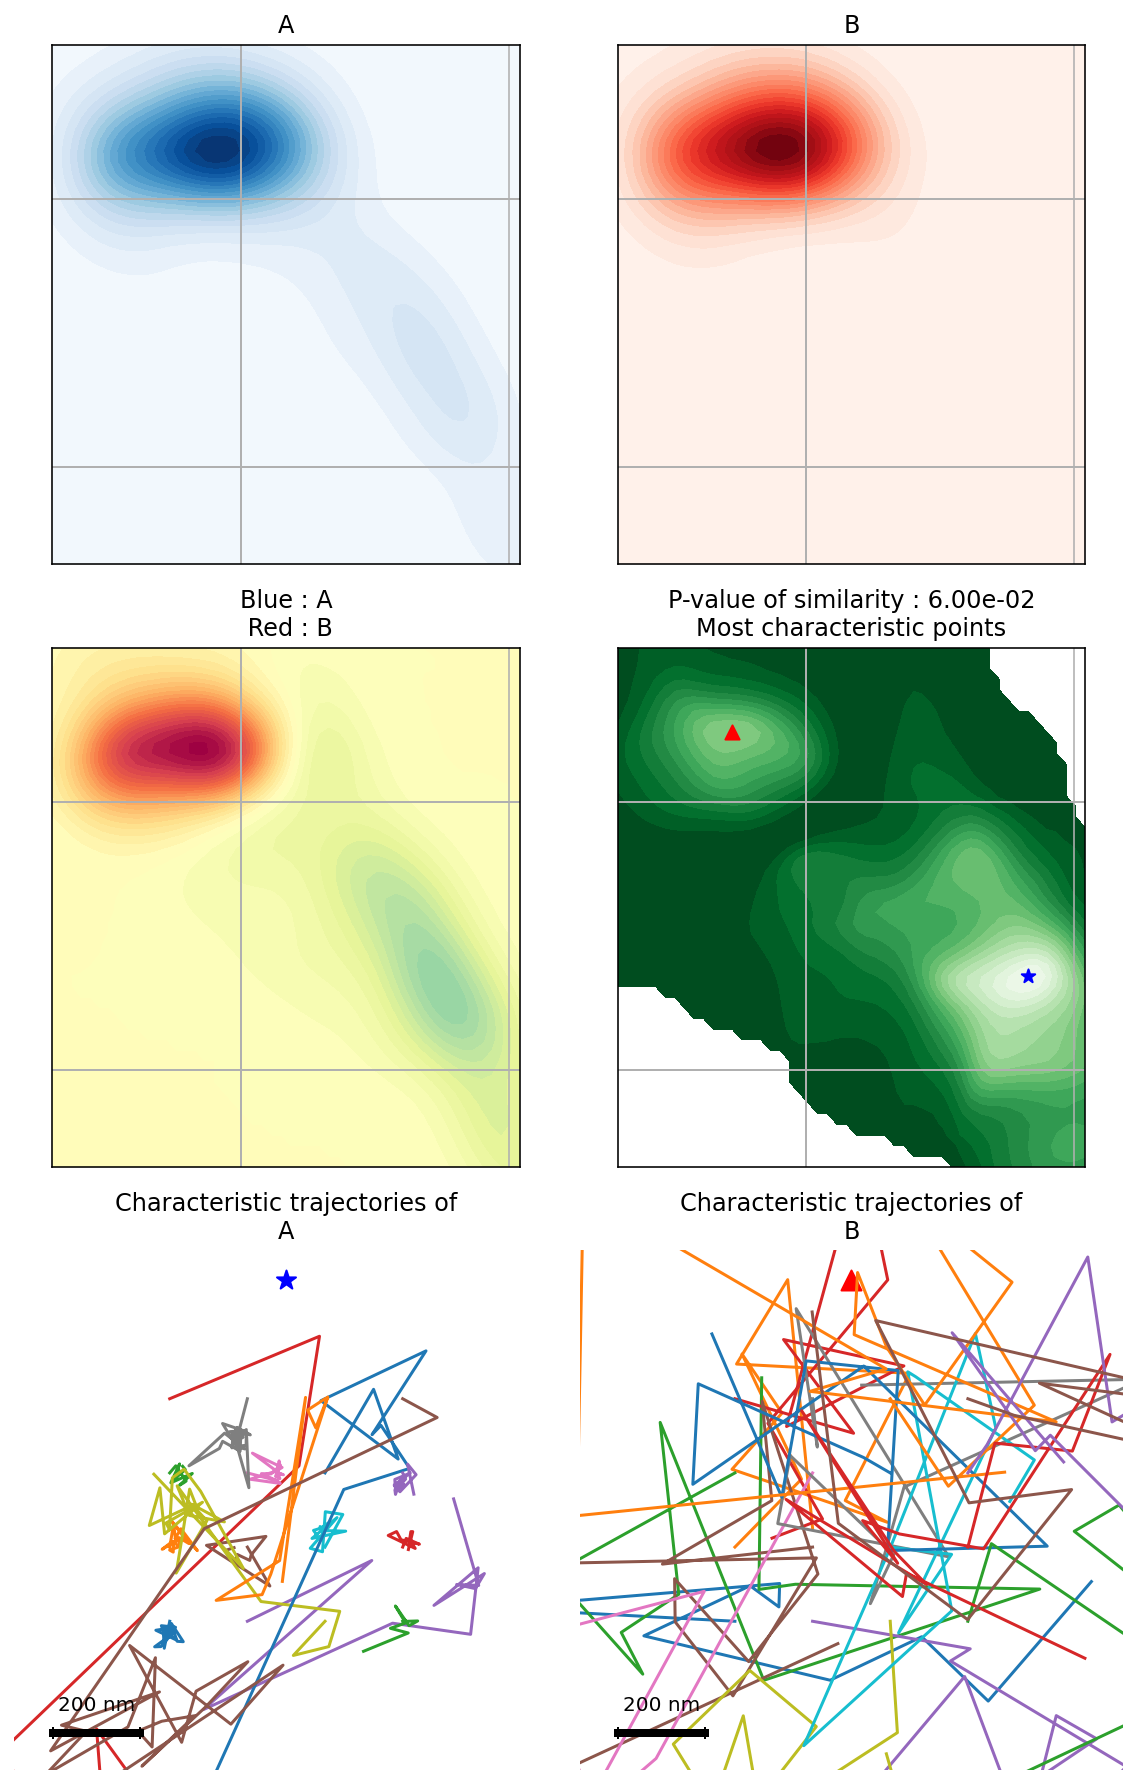

In [21]:
mmd_group.plot_discriminant_trajs(cond1={"condition":"A"},cond2={"condition":"B"})

/Users/hverdier/palm-tools/src/palm_tools/analysis/mmd_analysis.py:819: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


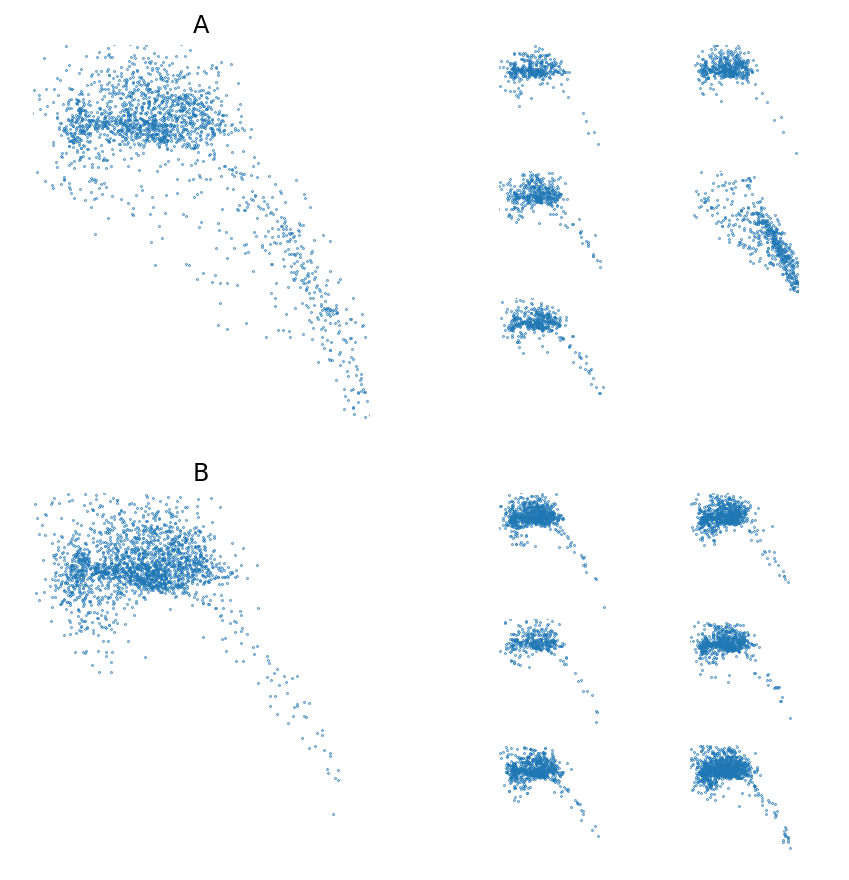

In [22]:
mmd_group.plot_latent_spaces(groups={"condition":["A","B"]},show_scatter=True)

In [23]:
mmd_unit = MMDInterUnitAnalysis(
    track_sets=tss,
    run_name="demo",
    n_processes=4
    )

In [24]:
mmd_unit.units

Adding units from tracksets: 100%|██████████| 11/11 [00:18<00:00,  1.65s/it, 1271 trajs from CONDITION B/Exp1/cellZone0/ROI.tif]       


latent_df has 11 units


{0: {'file': 'CONDITION A/Experience1/CellZone1/ROI.tif'},
 1: {'file': 'CONDITION A/Experience1/CellZone0/ROI.tif'},
 2: {'file': 'CONDITION A/Experience0/CellZone2/ROI.tif'},
 3: {'file': 'CONDITION A/Experience0/CellZone1/ROI.tif'},
 4: {'file': 'CONDITION A/Experience0/CellZone0/ROI#0.tif'},
 5: {'file': 'CONDITION B/Exp0/cellZone2/ROI#0.tif'},
 6: {'file': 'CONDITION B/Exp0/cellZone1/ROI.tif'},
 7: {'file': 'CONDITION B/Exp0/cellZone0/ROI.tif'},
 8: {'file': 'CONDITION B/Exp1/cellZone2/ROI.tif'},
 9: {'file': 'CONDITION B/Exp1/cellZone1/ROI.tif'},
 10: {'file': 'CONDITION B/Exp1/cellZone0/ROI.tif'}}

In [25]:
mmd_unit.process()